# 1. 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np

# 2. 데이터 불러오기

In [2]:
df = pd.read_csv('../data/carrier_reefer_data_01_to_08_and_12.csv')

In [3]:
df.head()

,alarm_codes,ambient_temperature,made_cd,operating_mode,operating_mode_str,reefer_id,return_air_temperature,supply_air_temperature,temperature_setpoint,when_created
0,NaN,-8.29,CARRIER,6.0,IDLE,RDMU5216890,2.92,3.09,3.0,2022-01-01 00:00:23
1,"[""AL60""]",3.90,CARRIER,3.0,COOL,RJCU6995820,-19.83,-20.47,-20.0,2022-01-01 00:01:08
2,NaN,-1.06,CARRIER,6.0,IDLE,CTEU5865614,-24.43,-25.05,-24.0,2022-01-01 00:01:18
3,"[""dAL86""]",9.62,CARRIER,3.0,COOL,SDCU6045746,-17.57,-19.11,-20.0,2022-01-01 00:01:26
4,NaN,-6.06,CARRIER,3.0,COOL,UKFU6720496,-28.10,-30.61,-30.0,2022-01-01 00:01:32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883975 entries, 0 to 883974
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   alarm_codes             165319 non-null  object 
 1   ambient_temperature     881033 non-null  float64
 2   made_cd                 883975 non-null  object 
 3   operating_mode          879638 non-null  float64
 4   operating_mode_str      879638 non-null  object 
 5   reefer_id               883975 non-null  object 
 6   return_air_temperature  883975 non-null  float64
 7   supply_air_temperature  883849 non-null  float64
 8   temperature_setpoint    883975 non-null  float64
 9   when_created            883975 non-null  object 
dtypes: float64(5), object(5)
memory usage: 67.4+ MB


In [5]:
# 문자열을 datetime으로 변경
import datetime

df['when_created'] = df['when_created'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

# 3. DEFROST가 발생한 데이터 찾기

## 3-1. 설정온도가 변하지 않는 컨테이너 찾기

In [6]:
print(f"CARRIER 컨테이너의 전체 개수는 {df['reefer_id'].nunique()}개 입니다.")

CARRIER 컨테이너의 전체 개수는 102개 입니다.


In [7]:
# 1. 컨테이너ID별로 분리

# 2. 설정 온도가 냉동이면서 설정 온도가 변하지 않는 경우만 필터링

In [8]:
import math

reefer_id_list = df['reefer_id'].unique()
temperature_list = []
for reefer_id in reefer_id_list:
    temperature_setpoint = df.loc[df['reefer_id'] == reefer_id, 'temperature_setpoint'].unique()
    if len(temperature_setpoint) == 1 and temperature_setpoint[0] < 0:
        temperature_list.append(math.floor(temperature_setpoint[0]))

pd.Series(temperature_list).value_counts()

-20    11
-18     4
-25     2
-19     2
-3      1
-21     1
-17     1
dtype: int64

- 영하 20도인 데이터가 가장 많으므로 영하 20도인 데이터만 사용한다.
- 영하 20도인 데이터의 개수

In [9]:
import math

reefer_id_list = df['reefer_id'].unique()
reefer_below_20 = []
for reefer_id in reefer_id_list:
    temperature_setpoint = df.loc[df['reefer_id'] == reefer_id, 'temperature_setpoint'].unique()
    if len(temperature_setpoint) == 1 and math.floor(temperature_setpoint[0]) == -20.0:
        print(reefer_id, df.loc[df['reefer_id'] == reefer_id].shape[0])
        reefer_below_20.append(reefer_id)

RJCU6995820 31087
BMOU9003717 21743
CBHU2805710 47
SKRU9200955 17
GESU9370000 22
SKRU8300707 2795
CRXU5278311 7
CWCU5722568 1766
CCLU1038527 5
TRIU6681373 2524
IKRU2301291 1671


## 3-2. 찾은 컨테이너에서 DEFROST가 발생한 데이터 찾기

In [10]:
reefer_in_defrost = []

for reefer_id in reefer_below_20:
    operating_mode_list = list(df.loc[df['reefer_id'] == reefer_id, 'operating_mode_str'].unique())
    if "DEFROST" in operating_mode_list:
        print(f"{reefer_id}컨테이너의 DEFROST 발생횟수: {df.loc[df['reefer_id'] == reefer_id, 'operating_mode_str'].value_counts()['DEFROST']}번")
        reefer_in_defrost.append(reefer_id)

RJCU6995820컨테이너의 DEFROST 발생횟수: 5303번
BMOU9003717컨테이너의 DEFROST 발생횟수: 920번
CBHU2805710컨테이너의 DEFROST 발생횟수: 1번
SKRU9200955컨테이너의 DEFROST 발생횟수: 1번
GESU9370000컨테이너의 DEFROST 발생횟수: 5번
SKRU8300707컨테이너의 DEFROST 발생횟수: 410번
CWCU5722568컨테이너의 DEFROST 발생횟수: 94번
TRIU6681373컨테이너의 DEFROST 발생횟수: 62번
IKRU2301291컨테이너의 DEFROST 발생횟수: 48번


## 3-3. DEFROST가 시작하기 전과 끝난 이후 각각 6개의 데이터가 있는 것만 추출하기

- DEFROST 전후 1시간 간격으로 데이터를 끊을 생각이다.

In [11]:
reefer_in_defrost

['RJCU6995820',
 'BMOU9003717',
 'CBHU2805710',
 'SKRU9200955',
 'GESU9370000',
 'SKRU8300707',
 'CWCU5722568',
 'TRIU6681373',
 'IKRU2301291']

In [12]:
def pop_sequence_number(num_list):
    """
    DEFROST가 발생한 인덱스를 뽑아내는 함수입니다.

    Inputs
    ----------
    num_list: DEFROST가 발생한 인덱스 번호(1차원 리스트)

    Return
    ------
    packet: DEFROST가 발생한 인덱스 번호 묶음(2차원 리스트)
    """
    packet = []
    tmp = []

    v = num_list.pop(0)
    tmp.append(v)

    while (len(num_list) > 0):
        vv = num_list.pop(0)
        if v+1 == vv:
            tmp.append(vv)
            v = vv
        else:
            packet.append(tmp)
            tmp = []
            tmp.append(vv)
            v = vv
    
    packet.append(tmp)
    return packet

In [13]:
defrost_idx_per_reefer = {}

# 컨테이너별 DEFROST가 발생한 인덱스 추출
for reefer_id in reefer_in_defrost:
    aa = df.loc[(df['reefer_id'] == reefer_id)].reset_index(drop=True)
    defrost_idx_per_reefer[reefer_id] = pop_sequence_number(list(aa.loc[aa['operating_mode_str'] == "DEFROST"].index))

In [14]:
# DEFROST포함 24개의 로그를 만들 수 있는 것만 추출

from tqdm import tqdm

drop_idx_list = []

for reefer_id in reefer_in_defrost:
    idx_bundle = defrost_idx_per_reefer[reefer_id]
    drop_idx_list = []
    for idx_list in tqdm(idx_bundle):
        standard_length = (24 - len(idx_list)) // 2
        if (idx_list[0] - standard_length < 0) or (idx_list[-1] + standard_length > df.loc[df['reefer_id'] == reefer_id].shape[0]):
            print(reefer_id, idx_list)
            drop_idx_list.append(idx_list)
    for idx in drop_idx_list:
        idx_bundle.remove(idx)

100%|██████████| 1/1 [00:00<?, ?it/s]


CBHU2805710 [0]


100%|██████████| 1/1 [00:00<?, ?it/s]


SKRU9200955 [3]


100%|██████████| 2/2 [00:00<00:00, 66.89it/s]


GESU9370000 [2, 3]
GESU9370000 [13, 14, 15]


 15%|█▌        | 5/33 [00:00<00:00, 41.46it/s]

CWCU5722568 [4, 5, 6]


 40%|████      | 6/15 [00:00<00:00, 48.94it/s]

IKRU2301291 [0, 1, 2]
IKRU2301291 [4, 5]


100%|██████████| 15/15 [00:00<00:00, 37.53it/s]


In [15]:
# DEFROST가 발생한 인덱스의 길이를 24로 고정
to_image_idx_list = {}

for reefer_id, idx_bundle in defrost_idx_per_reefer.items():
    for i, idx_list in enumerate(idx_bundle):
        if len(idx_list) != 0:
            standard_length = (24 - len(idx_list)) // 2
            start = list(range(idx_list[0]-standard_length, idx_list[0]))
            end = list(range(idx_list[-1]+1, idx_list[-1]+standard_length+1))
            start.extend(idx_list)
            start.extend(end)
            if len(start) == 23:
                start.append(start[-1]+1)
            defrost_idx_per_reefer[reefer_id][i] = start

# 4. 시계열 데이터를 이미지로 변환하기

In [16]:
#!pip install pyts

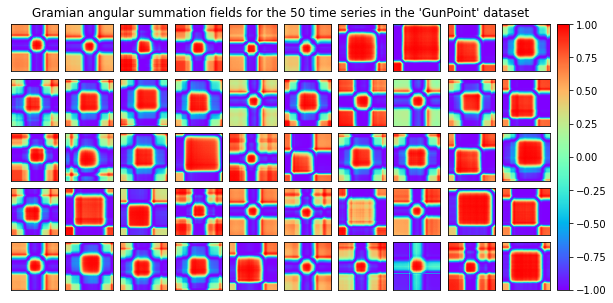

In [17]:
# Author: Johann Faouzi <johann.faouzi@gmail.com>
# License: BSD-3-Clause

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from pyts.datasets import load_gunpoint

# Load the GunPoint dataset
X, _, _, _ = load_gunpoint(return_X_y=True)

# Get the Gramian angular summation fields for all the time series
gaf = GramianAngularField()
X_gaf = gaf.fit_transform(X)

# Plot the 50 Gramian angular fields
fig = plt.figure(figsize=(10, 5))

grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.1, share_all=True,
                 cbar_mode='single')
for i, ax in enumerate(grid):
    im = ax.imshow(X_gaf[i], cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)

fig.suptitle("Gramian angular summation fields for the 50 time series in the "
             "'GunPoint' dataset", y=0.92)

plt.show()

## 4-1. 이미지로 변환할 데이터 구성하기

In [31]:
from pyts.approximation import PiecewiseAggregateApproximation

concat_list_at = []
concat_list_rat = []
concat_list_sat = []

idx_list_all = []

for reefer_id, idx_bundle in defrost_idx_per_reefer.items():
    for idx_list in tqdm(idx_bundle):
        if len(idx_list) != 0 and len(idx_list) > 13:
            df_tmp = df.loc[df['reefer_id'] == reefer_id].reset_index(drop=True)
            df_tmp = df_tmp.fillna(method='ffill')
            df_for_gaf = df_tmp.loc[idx_list].reset_index(drop=True)

            idx_list_all.append([idx_list, reefer_id])

            concat_list_at.append(df_for_gaf[['ambient_temperature']].T)
            concat_list_rat.append(df_for_gaf[['return_air_temperature']].T)
            concat_list_sat.append(df_for_gaf[['supply_air_temperature']].T)

100%|██████████| 280/280 [00:13<00:00, 20.81it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 13/13 [00:00<00:00, 28.60it/s]


In [32]:
len(idx_list_all), len(pd.concat(concat_list_at))

(1003, 1003)

## 4-1. GAFS, GAFD 방식을 각각 적용하여 이미지로 변환하기

In [33]:
gasf = GramianAngularField(method='summation')
X_gasf_at = gasf.fit_transform(pd.concat(concat_list_at))
X_gasf_rat = gasf.fit_transform(pd.concat(concat_list_rat))
X_gasf_sat = gasf.fit_transform(pd.concat(concat_list_sat))


gadf = GramianAngularField(method='difference')
X_gadf_at = gadf.fit_transform(pd.concat(concat_list_at))
X_gadf_rat = gadf.fit_transform(pd.concat(concat_list_rat))
X_gadf_sat = gadf.fit_transform(pd.concat(concat_list_sat))

In [34]:
image_data_dict = {
    "gasf_at":[X_gasf_at.tolist(), idx_list_all], 
    "gasf_rat":[X_gasf_rat.tolist(), idx_list_all],
    "gasf_sat":[X_gasf_sat.tolist(), idx_list_all],
    "gadf_at":[X_gadf_at.tolist(), idx_list_all],
    "gadf_rat":[X_gadf_rat.tolist(), idx_list_all],
    "gadf_sat":[X_gadf_sat.tolist(), idx_list_all]
}

# 5. 데이터 내보내기

In [41]:
import json

with open('../data/image_data.json', 'w') as f:
    json.dump(image_data_dict, f, indent=4)